# Tumor Mutation Classification

In this project, we will analyze a dataset of tumor gene mutations and their associated 'risk category', which indicates the risk of malignancy for that mutation in the human condition. The dataset was hand-labeled and released by the team of clinical pathologists at Memorial Sloan Kettering in 2018. Our objective of this project is to fit the dataset into various machine learning models to predict the risk category while accounting for highly unbalanced classes. Several methods for text feature generation will be explored. We will then use the synthetic minority over-sampling technique (SMOTE) to resample the dataset to make the numbers of categories more even. The last step is to compare machine learning methods on our feature sets and tune our models to achieve maximum performance.

In [24]:
import pandas as pd
import boto3
import io

import re
import spacy

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from collections import Counter
import matplotlib.pyplot as plt

import csv

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, decomposition, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report

from gensim import models
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

nlp = spacy.blank('en')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In this section we will load in all of our data. The text also needs to be cleaned of all non-legitimate words, such as figure references and parentheses. This will be accomplished using regular expressions. We have been provided a training dataset of several thousand labeled peer-reviewed journal articles. We have also been provided a testing dataset for external validation, but this dataset is not labeled so we will not be able to use it at this time to assist with tuning our model.

In [2]:
# Set up packages for loading in data
client = boto3.client('s3') #low-level functional API

resource = boto3.resource('s3') #high-level object-oriented API

In [3]:
# Load in training data labels
obj = client.get_object(Bucket='thinkful-capstone', Key='training_variants')
stream = io.BytesIO(obj['Body'].read())
training_variants = pd.read_csv(stream)

In [4]:
print(training_variants.head())
print(training_variants.shape)

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
(3321, 4)


In [5]:
# Load in training data text articles
obj = client.get_object(Bucket="thinkful-capstone",Key="training_text")
raw_training_text = obj["Body"].read()
training_text = raw_training_text.decode('utf-8')
print(training_text[:10000])

ID||Text
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

In [6]:
# Eliminate references and abbreviations within parentheses
print(len(training_text))
training_text = re.sub(' \(Fig \d+.+?\)', '', training_text)
training_text = re.sub(' \(Fig\. \d+.+?\)', '', training_text)
training_text = re.sub(' \(\d.*?\)', '', training_text)
training_text = re.sub(' \([A-Z]\)', '', training_text)
print(len(training_text))
print(training_text[:4000])

211296707
205598350
ID||Text
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cycl

In [7]:
# Split text file into list of documents
training_list = training_text.split('||')
training_list = training_list[2:]
print(len(training_list))

3321


In [8]:
# Load training text list into dataframe
texts_df = pd.DataFrame(training_list, columns = ['text'])

# Merge text dataframe with labels dataframe
train = pd.concat([training_variants, texts_df], axis=1)
print(train.head())
print(train.shape)

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...  
(3321, 5)


In [9]:
# Temporary cell to reduce data size
#train = train[:400]
#print(train.shape)

Now that the data is loaded into a dataframe, let's do some preliminary data exploration.

In [10]:
print(train['Class'].value_counts())

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


We have 3321 total datapoints to work with, and it looks like we are dealing with significant class imbalance. Class 7 has 953 datapoints, while Class 8 has only 19. We will have to address this class imbalance with our experiment design. Additionally, the labels have been anonymized, which means we cannot draw any insight about what these classes might signify. 

# Experiment Design

The prevalence of class imbalance has serious implications for our analysis. First and foremost, we must establish our scoring metric. The purpose here is to use the relevant clinical texts to predict the mutation category for each gene/mutation pair. While we want the predictions to be as accurate as possible, simple classification accuracy is not a representative way to judge models that are built on class imbalance, as they may achieve high accuracy by simply predicting the most common class every time. <br>

Given that we are working with a multi-label classifier, the most appropriate scoring metric is log loss. Log loss quantifies the accuracy of a classifier by penalising false classifications, and heavily penalises classifiers that are confident about an incorrect classification. For this reason, it is more suitable than traditional accuracy for datasets with class imbalance. <br>

When feeding our data into the predictive models, each resulting prediction is associated with a probability, and each probability is multiplied by one another to get the overall probability that all of those outcomes occurred together. As each event gets multiplied in, the final number gets smaller and smaller. So, we take the log to put the number in a more accessible range. The number is then multiplied by -1 to maintain the convention that a lower loss score is better. We will be choosing models with log loss scores closer to 0. We will also look at the precision and recall via the F1 score. Though these are not optimized for multi-label classification, they will be interesting to consider. <br>

Source: https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/, https://www.kaggle.com/dansbecker/what-is-log-loss

We will also try oversampling the lesser-represented categories and apply our machine learning models on the oversampled datasets, judging by their log loss scores. Oversampling can be achieved by generating duplicate datapoints or by generating new synthetic datapoints via SMOTE, the Synthetic Minority Oversampling Technique. We will use SMOTE, a feature of the imbalanced learn package. <br>

I will use various methods of feature generation including classic NLP techniques such as bag-of-words, tf-idf, and n-grams. These methods of feature generation will be applied to both the original and oversampled datasets. They will then be subjected to various machine learning models. Decision trees are known to perform well on unbalanced datasets, so this model may prevail on the original data. However, Naive Bayes is known to perform well on natural langauge, so once the dataset is oversampled it is possible that Naive Bayes will perform the best. All machine learning models will be run with a variety of hyperparameters on a variety of datasets, and the permutation with the best log-loss score will be chosen to move forward.

It is important to note that by convention, grid search always tries to maximize its score so loss functions like log loss will have to be negated such that the lowest log loss score will be the highest negated score.

# Data Cleaning

The data is relatively clean already, and contains no NaN values. It needs to be tokenized so it can be processed into readable pieces of data. We will use spaCy to tokenize the data and create a new column with a list of the tokens for each row. Furthermore, we will convert all tokens that are not stop words or punctuation to lemmas to reduce the noise from unnecessary words.

In [11]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'off', 's', 'ain', "needn't", 'couldn', 'all', 'her', 'has', 'of', 'ma', 'before', 'during', 'over', 'which', 're', 'yours', "don't", 'our', 'them', 'y', 'each', 'that', 'wasn', "mustn't", 'very', 'not', 'from', 'up', 'when', 'd', 'until', 'now', 'below', 'she', 'doing', 'down', 'am', 'hadn', 'wouldn', "won't", 'herself', 'the', 'me', "couldn't", 'between', 'on', "you're", 'myself', 'haven', 'won', 'through', 'only', "you've", 'then', 'no', 'having', 'don', 'what', 'being', 'yourselves', 'shouldn', 'him', 'than', 'where', 'll', 'at', 'own', 'if', "didn't", 'were', 'while', 'most', 'who', "hadn't", 'an', "wouldn't", 'for', 'under', 'its', 'doesn', "isn't", 'is', 'and', 'mightn', 'any', 'against', "hasn't", 'because', 'to', 've', 'it', 'mustn', 'shan', 'so', 'they', 'isn', 'their', 'whom', "doesn't", 'further', "shouldn't", 'have', 'by', 'needn', "should've", 'does', 'or', 'after', "aren't", 'did', 'there', 'you', 'had', "you'll", 'too', 'as', 'will', 'those', 'be', 'about', 'nor', 'few

In [12]:
print('beginning lemmatization')
train['spacy_tokens'] = train['text'].apply(lambda x: nlp(x))

def lemmatize(x):
    intermediate_lemmas = [token.lemma_.lower() for token in x
            if not token.is_punct]
    return [lemma for lemma in intermediate_lemmas
           if lemma not in stop_words
           and lemma != "-PRON-"
           and lemma != " "
           ]

train['lemmas'] = train['spacy_tokens'].apply(lambda x: lemmatize(x))
print(train.head())

beginning lemmatization
   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                text  \
0  Cyclin-dependent kinases (CDKs) regulate a var...   
1   Abstract Background  Non-small cell lung canc...   
2   Abstract Background  Non-small cell lung canc...   
3  Recent evidence has demonstrated that acquired...   
4  Oncogenic mutations in the monomeric Casitas B...   

                                        spacy_tokens  \
0  (Cyclin, -, dependent, kinases, (, CDKs, ), re...   
1  ( , Abstract, Background,  , Non, -, small, ce...   
2  ( , Abstract, Background,  , Non, -, small, ce...   
3  (Recent, evidence, has, demonstrated, that, ac...   
4  (Oncogenic, mutations, in, the, monomeric, Cas...   

                         

Now that we have our lemmatized datapoints, we must convert them into a list of strings to feed to our feature generators.

In [13]:
joined_lemma_documents = [
    ' '.join([str(word) for word in text])
    for text in train['lemmas'].values.tolist()
]

In [14]:
# Update training dataframe with lemmatized documents
train['lemmatized'] = joined_lemma_documents

In [15]:
# Reserve 20% of training dataset for external validation
train, test = train_test_split(train,
                                test_size = 0.2,
                                random_state = 1)

In order to reduce unnecessary input to the vectorizer, we want to cut each document to its most important features. But how will we know how many features to keep? First, we will create a dictionary of all the words in the corpora and their frequencies using Counter. Then we will graph the words by frequency to see how many words make up the majority of our corpora.

In [16]:
# Create list of 500 most common words per training set to reduce features in testing set
# Create a dictionary of words and frequencies
counter = Counter()

In [32]:
# Iterate through each training document, split into words and add words/frequencies to Counter
for document in train['lemmatized']:
    words = document.split(' ')
    counter.update(words)

In [33]:
# Convert term/frequency dictionary to list sorted by frequency
word_frequencies = sorted(
                        [[key, value] for key, value in counter.items()],
                        key = lambda x: x[1],
                        reverse = True
                        )

print(word_frequencies[:2])

[['mutation', 528768], ['cell', 482300]]


Total number of terms: 205136


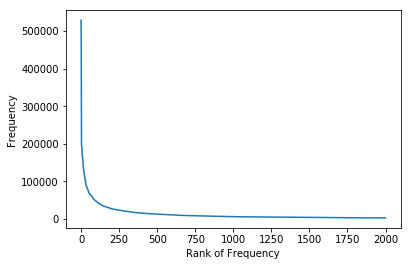

In [34]:
# Plot term frequency, trim list to 2000 most common words for easier visualization
print('Total number of terms:', len(word_frequencies))
trim_length = 2000
trim_frequencies = word_frequencies[:trim_length]
frequency_X = list(range(len(trim_frequencies)))
frequency_Y = [frequency_pair[1] for frequency_pair in trim_frequencies]
plt.plot(frequency_X, frequency_Y)
plt.xlabel('Rank of Frequency')
plt.ylabel('Frequency')
plt.show()

It appears that the term frequencies drop off after the first 250 words. After 250, the term frequencies become very sparse and will likely add no value to our model. Still, we will keep the 500 most common words for input to our feature generator to ensure that we are not losing any potentially valuable features. We will utilize the max_feature hyperparameter in the tf-idf and count vectorizer, which will allow us to reduce the dataset to these 500 most common words in one simple step.

However, when we run our external validation set (reserved 20%) we cannot verify it unless our validation set has the same features as our training set. For this reason, we will extract the 500 most common words from our training set and reduce our validation documents to these 500 words. While this significantly changes our testing data, it is the only way to evaluate the legitimacy of our chosen model. This is a common problem in natural language processing, and typically handled by either ignoring all unseen words in the testing document or lumping them into a single 'unknown' type.

In [35]:
# Create list of n most common words per training document
common_words = [frequency_pair[0] for frequency_pair in word_frequencies[:500]]

reduced_documents = []
# Reducing test documents to 500 most common words per training set
for document in test['lemmatized'].values.tolist():
    words = document.split(' ')
    reduced_document = [word for word in words
                       if word in common_words]
    reduced_document = ' '.join(reduced_document)
    reduced_documents.append(reduced_document)
    
test['lemmas'] = reduced_documents

In [ ]:
# Exporting training/testing dataframes to csv'
train.to_csv('lemmatized_train.csv')
test.to_csv('lemmatized_test.csv')

# Grid Search: Feature Generation, Dimensionality Reduction, Oversampling and Machine Learning

In this cell, we will create a pipeline that iterates through several different parameters and models. For feature generation, we will attempt both tf-idf vectorization and bag-of-words vectorization, which will convert our list of strings into sparse dataframes. Bag-of-words is a simplistic representation of text that considers only term frequency and assumes that position doesn't matter. Tf-idf is a more nuanced representation of text that considers the term frequency as well the inverse document frequency, which gives more information about how significant each word is. For example, a common word such as "the" may score high in term frequency, but having high term frequency in every document would diminish its meaning and thus its tf-idf score. Both bag-of-words and tf-idf have several parameters that will be optimized through the gridsearch. For brevity's sake, we are only tuning the max_df and min_df, which represent the maximum and minimum number of times a term should appear in any given document.

Beyond using singular words or lemmas as features for classification, we can also use groupings of words that appear together, as they may convey more meaning than each word isolated by itself. We will use the native ngram_range hyperparameter to broaden our dataset to include common bigrams as well. Bigrams (2 consecutive words) are preferable as groupings larger than 2 words in a dataset this small would likely create unnecessary noise without adding any insight.

We will likely need a way to reduce dimensionality, as dimensionality reduction reduces the storage and computation requirements of our model.  We will implement some permutations of the pipeline with Truncated Singular Value Decomposition which works well with sparse data. This transformation is termed Latent Semantic Analysis, a technique that is known to combat polysemy and synonymy. For the permutations that use Truncated SVD, I chose to reduce to 500 components based on a scree plot that was generated outside of this notebook. In the scree plot, 500 components appeared to capture roughly 85% of the variance of the dataset, a well-known standard for dimensionality reduction.

Source: http://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis

As mentioned before, we will also implement oversampling via SMOTE to combat the class imbalance. SMOTE (Synthetic Minority Oversampling Technique) uses the K Neighbors algorithm to synthesize new datapoints that resemble the existing classes. The default number of neighbors to use is 5. In an effort to reduce computational complexity, we will hold off on tuning other parameters.

Finally, we will apply several different machine learning models and evaluate their performance using cross-validation with log-loss scoring. First, we will try a multinomial Naive Bayes model, which naively assumes that all features are independent from one another. The multinomial model is commonly used for NLP problems and works under the bag-of-words assumption that position doesn't matter. The sklearn MultinomialNB documentation states that "the multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."

Source: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf, http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will also try random forests, as ensemble models tend to be robust against overfitting. Random forest language models have been shown to generalize well to unseen data, which is important in predictive modeling. The random forest has several parameters that will be tuned with the high dimensionality of the dataset in mind.

Source: http://www.aclweb.org/anthology/W04-3242


In [21]:
# Load in training dataframe
train = pd.read_csv('~/tumor-mutation-classification/lemmatized_train.csv')
X = train['lemmatized']
Y = train['Class']

# Logistic Regression Pipeline

In [22]:
# Set up pipeline
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
#    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', LogisticRegression())
])

# Feature generation parameters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]
# Dimensionality reduction parameters
n_components = [500]
# Oversampling parameters
smote_kind = ['regular','borderline1']
# Machine learning model parameters 
C_values = [1e-3, 1e-1, 1, 100]

param_grid = [
    # Tfidf permutations first
    # With and without oversampling, ngrams
    {
        'feat_gen': [TfidfVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [TfidfVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    # Bag of words permutations next
    # With and without oversampling, ngrams
    {
        'feat_gen': [CountVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'oversample__kind': smote_kind,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    },
    {
        'feat_gen': [CountVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'machine': [LogisticRegression(random_state=1)],
        'machine__C': C_values
    }
]

# Run grid search with cross validation
print('running grid search with logistic regression...')
grid = GridSearchCVProgressBar(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')
grid.fit(X, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

Now that we have run the grid search, we will export our findings to a csv so that we can access them without having to run the expensive grid search every time. We will create a function that can be re-used throughout the notebook to export all the grid search findings from each machine learning model type.

In [ ]:
# Sort and export all results for grid search to csv
def export_gridsearch_to_csv(gs_clf, export_file):
    with open(export_file, 'w') as outfile:
        csvwriter = csv.writer(outfile, delimiter=',')

        # Create the header using the parameter names 
        header = ["mean","std", "params"]

        csvwriter.writerow(header)

        sorted_by_score = sorted(gs_clf.grid_scores_, key = itemgetter(1), reverse=True)

        for config in sorted_by_score:
            # Get mean and standard deviation
            mean = np.abs(config[1])
            std = np.std(config[2])
            row = [mean,std, str(config[0])]

            csvwriter.writerow(row)

filename = datetime.datetime.utcnow().strftime('logistic_gridresults_%Y%m%d_%H:%M.csv')       
export_gridsearch_to_csv(grid, filename)

# Random Forest

In [ ]:
# Set up pipeline
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
#    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', RandomForestClassifier())
])

# Feature generation parameters
maxdf = [0.25, 0.5, 0.75]
mindf = [0.01, 0.05, 0.1]
# Dimensionality reduction parameters
n_components = [500]
# Oversampling parameters
smote_kind = ['regular','borderline1']
# Machine learning model parameters 
rf_max_depth = [30, 60, 100]
rf_min_samples_split = [430]	# 430 represents 5% of the dataset after oversampling
rf_n_estimators = [10]

param_grid = [
    # Tfidf permutations with and without n-grams
    # Removed permutations with CountVectorizer after logistic regression demonstrated poor log loss scores
    # Removed permutations without oversampling after logistic regression demonstrated poor log loss scores
    {
        'feat_gen': [TfidfVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    },
        {
        'feat_gen': [TfidfVectorizer(max_features = 500, ngram_range=(2,2))],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    }
]
# Run grid search with cross validation
print('running grid search with random forest...')
grid = GridSearchCVProgressBar(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')
grid.fit(X, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

In [ ]:
filename = datetime.datetime.utcnow().strftime('rf_gridresults_%Y%m%d_%H:%M.csv')       
export_gridsearch_to_csv(grid, filename)

# XGBoost

In [ ]:
# Set up pipeline
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
#    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', XGBClassifier())
])

# Feature generation parameters
# max_df and min_df values reduced to best-performing values from logistic/random forest grid search
maxdf = [0.75]
mindf = [0.05]
# Dimensionality reduction parameters
n_components = [500]
# Oversampling parameters
smote_kind = ['regular','borderline1']
# Machine learning model parameters 
xg_booster = ['gbtree','gblinear']
xg_learning_rate = [0.01, 0.1, 0.3]
xg_max_depth = [30, 60, 100]
xg_subsample = [0.5, 1]

param_grid = [
# Tfidf permutations with and without n-grams
# Removed permutations with CountVectorizer after logistic regression demonstrated poor log loss scores
# Removed permutations without oversampling after logistic regression demonstrated poor log loss scores
    {
        'feat_gen': [TfidfVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [XGBClassifier(random_state = 1)],
        'machine__booster': xg_booster,
        'machine__learning_rate': xg_learning_rate,
        'machine__max_depth': xg_max_depth,
        'machine__subsample': xg_subsample
    },
        {
        'feat_gen': [TfidfVectorizer(max_features = 500, ngram_range=(2,2))],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine__booster': xg_booster,
        'machine__learning_rate': xg_learning_rate,
        'machine__max_depth': xg_max_depth,
        'machine__subsample': xg_subsample
    }
]
# Run grid search with cross validation
print('running grid search with XGBoost...')
grid = GridSearchCVProgressBar(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')
grid.fit(X, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

In [ ]:
filename = datetime.datetime.utcnow().strftime('xg_gridresults_%Y%m%d_%H:%M.csv')       
export_gridsearch_to_csv(grid, filename)

# Naive Bayes Pipeline (Multinomial)

In [ ]:
# Set up pipeline
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
#    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', MultinomialNB())
])

# Feature generation parameters
# max_df and min_df values reduced to best-performing values from logistic/random forest grid search
maxdf = [0.75]
mindf = [0.05]
# Dimensionality reduction parameters
n_components = [500]
# Oversampling parameters
smote_kind = ['regular','borderline1']
# Default machine learning model parameters 

param_grid = [
# Tfidf permutations with and without n-grams
# Removed permutations with CountVectorizer after logistic regression demonstrated poor log loss scores
# Removed permutations without oversampling after logistic regression demonstrated poor log loss scores
    {
        'feat_gen': [TfidfVectorizer(max_features = 500)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [MultinomialNB()],
    },
        {
        'feat_gen': [TfidfVectorizer(max_features = 500, ngram_range=(2,2))],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        #'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [MultinomialNB()],
    }
]
# Run grid search with cross validation
print('running grid search with Naive Bayes...')
grid = GridSearchCVProgressBar(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')
grid.fit(X, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')


In [ ]:
filename = datetime.datetime.utcnow().strftime('nb_gridresults_%Y%m%d_%H:%M.csv')       
export_gridsearch_to_csv(grid, filename)

Now that all of our preliminary pipelines have been run, we can take a look at the resulting log loss scores and judge which machine learning model was the most effective on this dataset.

# Evaluating grid search results

In [37]:
logistic_results = pd.read_csv('scripts/logistic_gridresults_20180629_00:02.csv')
nb_results = pd.read_csv('scripts/nb_gridresults_20180703_18:04.csv')
rf_results = pd.read_csv('scripts/rf_gridresults_20180701_22:50.csv')
xg_results = pd.read_csv('scripts/xg_gridresults_20180630_17:46.csv')

In [4]:
best_logistic = pd.Series(['logistic', logistic_results['mean'][0], logistic_results['std'][0], logistic_results['params'][0]])
best_nb = pd.Series(['naive bayes', nb_results['mean'][0], nb_results['std'][0], nb_results['params'][0]])
best_rf = pd.Series(['random forest', rf_results['mean'][0], rf_results['std'][0], rf_results['params'][0]])
best_xg = pd.Series(['xgboost', xg_results['mean'][0], xg_results['std'][0], xg_results['params'][0]])
best_gridresults = pd.DataFrame().append([best_logistic, best_nb, best_rf, best_xg], ignore_index=True)
best_gridresults.columns = ['classifier','mean','std','params']
best_gridresults = best_gridresults.sort_values(by=['mean'], ascending=True)
print(best_gridresults)

      classifier      mean       std  \
2  random forest  1.832495  0.011121   
1    naive bayes  1.839022  0.044531   
3        xgboost  1.863806  0.055248   
0       logistic  1.888993  0.061842   

                                              params  
2  {'feat_gen': TfidfVectorizer(analyzer='word', ...  
1  {'feat_gen': TfidfVectorizer(analyzer='word', ...  
3  {'feat_gen': TfidfVectorizer(analyzer='word', ...  
0  {'feat_gen': TfidfVectorizer(analyzer='word', ...  


In [6]:
print(best_gridresults['params'][2])

{'feat_gen': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=500, min_df=0.05,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'feat_gen__max_df': 0.75, 'feat_gen__min_df': 0.05, 'machine': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=430,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False), 'machine__max_depth': 30, 'machine__min_samples_split': 430, 'machin

It appears that with the lowest log loss score of 1.83, the random forest classifier performed the best on our training dataset. Decision trees/random forests are known to perform well on imbalanced datasets, which we are currently working with. This model used bigrams as features with max_depth = 30 and min_samples_split = 430. One option now is to use the hyperparameters determined from this grid search to test new methods of feature generation such as word2vec, a common unsupervised neural network approach for NLP. The resulting log loss scores from other methods of feature generation will be compared to this baseline score of 1.83. The hyperparameters are as follows: <br>
- Feature Generator: TfidfVectorizer
- max_df = 0.75
- max_features = 500
- min_df = 0.05
- ngram_range = (2,2)
- oversample kind = regular
- Classifier: RandomForestClassifier
- max_depth = 30
- min_samples_split = 430
- n_estimators = 10


In [39]:
for element in rf_results['params']:
    print(element)

{'feat_gen': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=500, min_df=0.05,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'feat_gen__max_df': 0.75, 'feat_gen__min_df': 0.05, 'machine': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=430,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False), 'machine__max_depth': 30, 'machine__min_samples_split': 430, 'machin

# Validation

Let's see how this set of hyperparameters performs on our external validation set.

In [25]:
# Load in training dataframe
print("loading in training/testing dataframes")
train = pd.read_csv('~/tumor-mutation-classification/scripts/lemmatized_train.csv')
X_train = train['lemmatized']
Y_train = train['Class']
test = pd.read_csv('~/tumor-mutation-classification/scripts/lemmatized_test.csv')
X_test = test['lemmas']
Y_test = test['Class']

loading in training/testing dataframes


In [37]:
# Set up pipeline
# Parameters reduced to best-performing parameters from prior grid search
def random_forest_validation(X_train, Y_train, X_test, Y_test):
    pipe = Pipeline(steps=[
        ('feat_gen', TfidfVectorizer(max_df = 0.75, min_df = 0.05, max_features = 500)),
        ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
        ('machine', RandomForestClassifier(max_depth = 30, min_samples_split = 430, n_estimators = 10, random_state = 1))
    ])

    pipe.fit(X_train, Y_train)
    Y_pred = pipe.predict(X_test)
    Y_pred_prob = pipe.predict_proba(X_test)

    print('Log Loss: ', log_loss(Y_test, Y_pred_prob))
    print('Accuracy: ', accuracy_score(Y_test, Y_pred))
    print('\nConfusion Matrix:\n', confusion_matrix(Y_test, Y_pred))
    print('\nClassification Report:\n', classification_report(Y_test, Y_pred))
    
random_forest_validation(X_train, Y_train, X_test, Y_test)

loading in training/testing dataframes
Log Loss:  1.71745463541
Accuracy:  0.371428571429

Confusion Matrix:
 [[30  5  2 14 16 18  3  7 12]
 [ 2 48  3  4  1  7 20 11  2]
 [ 3  3 11  2  1  1  1  0  0]
 [21  8  8 45 13 14  5  7 20]
 [ 5  1  4  4 20  7  3  0  1]
 [ 3  2  1  2  3 35  2  0  0]
 [14 55 28  7  8  5 50 13 12]
 [ 0  0  0  0  0  0  2  1  1]
 [ 0  0  0  0  0  0  1  0  7]]

Classification Report:
              precision    recall  f1-score   support

          1       0.38      0.28      0.32       107
          2       0.39      0.49      0.44        98
          3       0.19      0.50      0.28        22
          4       0.58      0.32      0.41       141
          5       0.32      0.44      0.37        45
          6       0.40      0.73      0.52        48
          7       0.57      0.26      0.36       192
          8       0.03      0.25      0.05         4
          9       0.13      0.88      0.22         8

avg / total       0.47      0.37      0.38       665



After running validation on our external dataset, we can see that we have a baseline of **1.72 log loss score** and **37% accuracy** with **0.38 f1-score** (combining precision and recall). Let us now alter a few steps of the process and feed these altered dataframes into the training model to see if we can get it to perform any better. First, we will try increasing the number of features in the vectorizer. Currently, the model is trained with the 500 most common words, but the corpus includes 205,136 unique words. We will experiment with increasing the number of words considered for the feature generator. After we find a set a changes that improves the training log loss score, we will validate it again using the external validation dataset. 

# Fine tuning the Random Forest

In [ ]:
# Retrying the random forest with 2000 most common words instead of 500
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer(max_df = 0.75, min_df = 0.05, max_features = 2000)),
    ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
    ('machine', RandomForestClassifier(max_depth = 30, min_samples_split = 430, n_estimators = 10, random_state = 1))
])

pipe.fit(X_train, Y_train)

Y_pred = pipe.predict(X_train)
Y_pred_prob = pipe.predict_proba(X_train)

print('Log Loss: ', log_loss(Y_train, Y_pred_prob))
print('Accuracy: ', accuracy_score(Y_train, Y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(Y_test, Y_pred))
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))


In [4]:
# Retrying the random forest with 2000 most common words instead of 500
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer(max_df = 0.75, min_df = 0.05, max_features = 2000)),
    ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
    ('machine', RandomForestClassifier(max_depth = 30, min_samples_split = 430, n_estimators = 10, random_state = 1))
])

pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_train)
Y_pred_prob = pipe.predict_proba(X_train)

print('Log Loss: ', log_loss(Y_train, Y_pred_prob))

Log Loss:  1.57133355091


Increasing the words in our vectorizer lowered the training log loss score from 1.83 to **1.57**. This is a change we will keep -- from now on, the max_features specified in the training model will be 2000. This also means that we will have to expand our testing documents to include include the 2000 common words instead of the original 500. 

Let's try altering the pipeline to include a step for dimensionality reduction, which was neglected in the initial run of the grid searches.

In [7]:
pipe_dimred = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer(max_df = 0.75, min_df = 0.05, max_features = 2000)),
    ('reduce_dim', decomposition.TruncatedSVD(n_components=250, random_state = 1)),
    ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
    ('machine', RandomForestClassifier(max_depth = 30, min_samples_split = 430, n_estimators = 10, random_state = 1))
])

pipe_dimred.fit(X_train, Y_train)
Y_pred = pipe_dimred.predict(X_train)
Y_pred_prob = pipe_dimred.predict_proba(X_train)

print('Log Loss: ', log_loss(Y_train, Y_pred_prob))

Log Loss:  1.67777067324


Adding a step in the pipeline for dimensionality reduction via TruncatedSVD did not demonstrate an improvement from the new baseline log loss score of 1.57, though we did see an improvement from the initial training score of 1.83 that resulted from keeping 500 common words. In this instance, we reduced the number of features by one half using 2000 words -- perhaps this eliminated too much information? Let's continue fine tuning this in future efforts, since dimensionality reduction can be very beneficial for reducing the time and storage space required of this large dataset.

** Conclusions: <br>
Higher max features in vectorizer/vocabulary for testing documents. <br>
Dimensionality reduction using Truncated SVD may or may not be beneficial.
**

Now that we know that increasing the number of words considered in our vectorizer benefits our model, we can experiment with the number of words we choose. We will wrap this section of experimentation in a function for efficiency. The dimensionality reduction step will be omitted for now and added again later when we have determined the best number.

In [10]:
def change_max_features(X_train, Y_train, max_ft):
    pipe = Pipeline(steps=[
        ('feat_gen', TfidfVectorizer(max_df = 0.75, min_df = 0.05, max_features = max_ft)),
        ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
        ('machine', RandomForestClassifier(max_depth = 30, min_samples_split = 430, n_estimators = 10, random_state = 1))
    ])

    pipe.fit(X_train, Y_train)
    Y_pred = pipe.predict(X_train)
    Y_pred_prob = pipe.predict_proba(X_train)

    print('Log Loss: ', log_loss(Y_train, Y_pred_prob))

In [11]:
change_max_features(X_train, Y_train, None)

Log Loss:  1.5337523908


In [12]:
change_max_features(X_train, Y_train, 100000)

Log Loss:  1.5337523908


In [13]:
change_max_features(X_train, Y_train, 50000)

Log Loss:  1.5337523908


In [14]:
change_max_features(X_train, Y_train, 25000)

Log Loss:  1.5337523908


In [15]:
change_max_features(X_train, Y_train, 10000)

Log Loss:  1.5337523908


In [16]:
change_max_features(X_train, Y_train, 5000)

Log Loss:  1.5337523908


In [17]:
change_max_features(X_train, Y_train, 2000)

Log Loss:  1.57133355091


After iterating through several values for how many word features to include in our vectorized dataframe, it appears that any number between 5000 words and all 2,000,000+ words yields the best log loss score at 1.53. We will move forward using 5000 words for simplicity's sake. At this time, we will reduce the vocabulary of the testing documents to 5000 words for our future validation.

In [26]:
# Identifying 5000 most common words per training documents to reduce the vocabulary of the testing documents
counter = Counter()

for document in train['lemmatized']:
    words = document.split(' ')
    counter.update(words)

word_frequencies = sorted(
                        [[key, value] for key, value in counter.items()],
                        key = lambda x: x[1],
                        reverse = True
                        )

common_words_5000 = [frequency_pair[0] for frequency_pair in word_frequencies[:5000]]

In [28]:
# Creating new test dataframe with 5000 most common words per training set
test_5k = test.copy()
reduced_documents_5000 = []

for document in test['lemmatized'].values.tolist():
    words = document.split(' ')
    reduced_document = [word for word in words
                       if word in common_words_5000]
    reduced_document = ' '.join(reduced_document)
    reduced_documents_5000.append(reduced_document)
    
test_5k['lemmatized'] = reduced_documents_5000

# Exporting updated testing dataframe to csv for future reference
test_5k.to_csv('lemmatized_test_5000.csv')

With 5000 words in our corpus, we will now re-run the grid search with more finely tuned parameters for the random forest model. Based on the best performing parameters from the initial random forest grid serach, we are narrowing down the range of values for max_df and min_df in the word vectorizer, and max_depth and min_samples_split for the random forest. I also opted to include dimensionality reduction parameters as options here to fine-tune the model further. Note: The grid search will be run in a script outside of this Jupyter notebook but the code will be pasted below.

In [ ]:
# Load in training dataframe
train = pd.read_csv('~/tumor-mutation-classification/lemmatized_train.csv')
X = train['lemmatized']
Y = train['Class']

# Set up pipeline
pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer()),
    ('reduce_dim', decomposition.TruncatedSVD()),
    ('oversample', SMOTE(k_neighbors = 5)),
    ('machine', RandomForestClassifier())
])

# Feature generation parameters
maxdf = [0.65, 0.75, 0.85]
mindf = [0.025, 0.05, .075]
# Dimensionality reduction parameters
n_components = [100, 500, 1000]
# Oversampling parameters
smote_kind = ['regular','borderline1']
# Machine learning model parameters 
rf_max_depth = [20, 30, 40]
rf_min_samples_split = [430, 860]	# 430 represents 5% of the dataset after oversampling
rf_n_estimators = [10]

param_grid = [
# Tfidf permutations with and without n-grams
# Removed permutations with CountVectorizer after logistic regression demonstrated poor log loss scores
# Removed permutations without oversampling after logistic regression demonstrated poor log loss scores
    {
        'feat_gen': [TfidfVectorizer(max_features = 5000)],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    },
        {
        'feat_gen': [TfidfVectorizer(max_features = 5000, ngram_range=(2,2))],
        'feat_gen__max_df': maxdf,
        'feat_gen__min_df': mindf,
        'reduce_dim__n_components': n_components,
        'oversample__kind': smote_kind,
        'machine': [RandomForestClassifier(random_state = 1)],
        'machine__max_depth': rf_max_depth,
        'machine__min_samples_split': rf_min_samples_split,
        'machine__n_estimators': rf_n_estimators
    }
]
# Run grid search with cross validation
print('running grid search with random forest...')
grid = GridSearchCVProgressBar(pipe, cv=3, param_grid=param_grid, verbose=2, scoring = 'log_loss')
grid.fit(X, Y)
print(f'best score: \n {grid.best_score_}')
print(f'best params:\n {grid.best_params_}')

Loading in results from the grid search run externally in a script...

In [46]:
rf2_results = pd.read_csv('scripts/rf2_gridresults_20180713_13:08.csv')
best_rf2 = pd.Series(['random forest', rf2_results['mean'][0], rf2_results['std'][0], rf2_results['params'][0]])
print(best_rf2)
print(best_rf2[3])

0                                        random forest
1                                              1.67208
2                                            0.0287829
3    {'feat_gen': TfidfVectorizer(analyzer='word', ...
dtype: object
{'feat_gen': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.65, max_features=5000, min_df=0.025,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'feat_gen__max_df': 0.65, 'feat_gen__min_df': 0.025, 'machine': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1

Now that we have identified the best performing parameters for our narrowed-down grid search, we can test them on our validation dataset. Our new set of parameters is 

In [66]:
# Load in training dataframe
print("loading in training/testing dataframes")
train = pd.read_csv('~/tumor-mutation-classification/scripts/lemmatized_train.csv')
X_train = train['lemmatized']
Y_train = train['Class']
test = pd.read_csv('~/tumor-mutation-classification/lemmatized_test_5000.csv')
X_test = test['lemmas']
Y_test = test['Class']

pipe = Pipeline(steps=[
    ('feat_gen', TfidfVectorizer(max_df = 0.65, min_df = 0.025, max_features = 5000, ngram_range = (1,1))),
    ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
    ('reduce_dim', decomposition.TruncatedSVD(n_components = 100)),
    ('machine', RandomForestClassifier(max_depth = 20, min_samples_split = 430, n_estimators = 10, random_state = 1))
])

pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
Y_pred_prob = pipe.predict_proba(X_test)

print('Log Loss: ', log_loss(Y_test, Y_pred_prob))
print('Accuracy: ', accuracy_score(Y_test, Y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(Y_test, Y_pred))
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

loading in training/testing dataframes
Log Loss:  1.63802579801
Accuracy:  0.406015037594

Confusion Matrix:
 [[53  2  2 14 16  0  9  9  2]
 [10 40  6  6  0  2 22 12  0]
 [ 4  1 11  2  2  0  2  0  0]
 [48  0  4 56 17  1  6  9  0]
 [10  1 11  3 10  1  9  0  0]
 [11  0  1  2  9 17  7  1  0]
 [13 32 31 14  0  3 78 19  2]
 [ 0  0  0  1  0  0  1  2  0]
 [ 1  0  0  0  0  0  0  4  3]]

Classification Report:
              precision    recall  f1-score   support

          1       0.35      0.50      0.41       107
          2       0.53      0.41      0.46        98
          3       0.17      0.50      0.25        22
          4       0.57      0.40      0.47       141
          5       0.19      0.22      0.20        45
          6       0.71      0.35      0.47        48
          7       0.58      0.41      0.48       192
          8       0.04      0.50      0.07         4
          9       0.43      0.38      0.40         8

avg / total       0.50      0.41      0.43       665



After running a second grid search in which the hyper-parameters were tuned to narrow in on the best-performing parameters from earlier, we found a set of parameters that improved our validation log loss score from 1.72 to **1.64**. The accuracy also improved from 37% to 41%, and the f1-score improved from 0.38 to 0.43. While these are significant improvements, the accuracy remains less than 50%, indicating that this product is not satisfactory for professional use. We will now explore other methods of feature representation.

# Word2Vec

So far, our methods of feature generation have been reliant on one-hot word vectors, which is a sparse representation with no information regarding the meaning or context of the word. We will now experiment with using Word2Vec, a package from Google that relies on distributed representation. Distributed representation means that each word is represented in several places, both as the "center" word of a phrase and as a "context" word for other words. The resulting word vectors are dense because they carry information about the surrounding words. This is how Word2Vec is able to retain information about word semantics and meaning. One implementation of Word2Vec is gensim's Doc2Vec, which uses similary technology to tag each document and work with the resulting tag vectors to determine document similarity.


'Essentially by lemmatization you make the input space sparser, which can help if you don't have enough training data.

But since Word2Vec is fairly big, if you have big enough training data, lemmatization shouldn't gain you much.'

In [2]:
# Add tag to each document
def tag_docs(df):
    docs = []
    for row in df.iterrows():
        docs.append(TaggedDocument(words = simple_preprocess(row[1]['text']), tags=[row[1]['Class']]))
        # simple preprocess converts a document into a list of tokens.
    return docs

In [6]:
# Train doc2vec model
def train_doc2vec_model(tagged_docs, window, size):
    sents = tagged_docs
    doc2vec_model = Doc2Vec(sents, size=size, window=window, iter=20, dm=1)
    return doc2vec_model

# Other parameter options: min_count=5, workers=1, epochs=20
# model.build_vocab(docs)

In [7]:
# Build the final vector feature for the classifier
def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs
    Y, X = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return Y, X

In [8]:
train = pd.read_csv('~/tumor-mutation-classification/lemmatized_train.csv')
test = pd.read_csv('~/tumor-mutation-classification/lemmatized_test_full.csv')

train_tagged = tag_docs(train)
test_tagged = tag_docs(test)
model = train_doc2vec_model(train_tagged, 5, 300)

y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [54]:
# Export vectorized dataframes
X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)
X_test_np = np.asarray(X_test)
y_test_np = np.asarray(y_test)

np.savetxt("d2v_X_train.csv", X_train_np, delimiter=",")
np.savetxt("d2v_y_train.csv", y_train_np, delimiter=",")
np.savetxt("d2v_X_test.csv", X_test_np, delimiter=",")
np.savetxt("d2v_y_test.csv", y_test_np, delimiter=",")

Now that we have our preprocessed dataframes exported and ready, we can feed them into our classifiers to get a basic picture of how they perform. We will run them through various external grid searches to determine the best hyperparameters to feed into our machine learning models and subsequently validate them below.

In [5]:
d2v_logistic_results = pd.read_csv('scripts/d2v_logistic_results_20180730_18:43.csv')
#d2v_nb_results = pd.read_csv('scripts/nb_gridresults_20180703_18:04.csv')
d2v_rf_results = pd.read_csv('scripts/d2v_rf_gridresults_20180730_18:39.csv')
d2v_xg_results = pd.read_csv('scripts/d2v_xg_gridresults_20180730_05:53.csv')

best_logistic = pd.Series(['logistic', d2v_logistic_results['mean'][0], d2v_logistic_results['std'][0], d2v_logistic_results['params'][0]])
#best_nb = pd.Series(['naive bayes', d2v_nb_results['mean'][0], d2v_nb_results['std'][0], d2v_nb_results['params'][0]])
best_rf = pd.Series(['random forest', d2v_rf_results['mean'][0], d2v_rf_results['std'][0], d2v_rf_results['params'][0]])
best_xg = pd.Series(['xgboost', d2v_xg_results['mean'][0], d2v_xg_results['std'][0], d2v_xg_results['params'][0]])
best_gridresults = pd.DataFrame().append([best_logistic, best_rf, best_xg], ignore_index=True)
best_gridresults.columns = ['classifier','mean','std','params']
best_gridresults = best_gridresults.sort_values(by=['mean'], ascending=True)
print(best_gridresults)

      classifier      mean       std  \
0       logistic  0.786146  0.037976   
2        xgboost  0.885314  0.051294   
1  random forest  1.429836  0.032435   

                                              params  
0  {'machine': LogisticRegression(C=0.1, class_we...  
2  {'machine': XGBClassifier(base_score=0.5, boos...  
1  {'machine': RandomForestClassifier(bootstrap=T...  


At first glance, it appears that using a Doc2Vec feature representation is highly beneficial to our log loss score. The logistic regression model performed best here, while the random forest performed best in the first round of grid searches. Let's confirm this on our validation set. 

In [6]:
X_train = pd.read_csv('~/tumor-mutation-classification/scripts/d2v_X_train.csv')
X_test = pd.read_csv('~/tumor-mutation-classification/scripts/d2v_X_test.csv')
y_train = pd.read_csv('~/tumor-mutation-classification/scripts/d2v_y_train.csv')
y_test = pd.read_csv('~/tumor-mutation-classification/scripts/d2v_y_test.csv')

print(best_gridresults['params'][0])

{'machine': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'machine__C': 0.1, 'reduce_dim__n_components': 50}


In [33]:
# Set up pipeline
# Parameters reduced to best-performing parameters from prior grid search
def logistic_validation(X_train, Y_train, X_test, Y_test):
    pipe = Pipeline(steps=[
        ('reduce_dim', decomposition.TruncatedSVD(n_components = 50)),
        ('oversample', SMOTE(k_neighbors = 5, kind = 'regular', random_state = 1)),
        ('machine', LogisticRegression(C = 0.1, penalty = 'l2', random_state = 1))
    ])

    pipe.fit(X_train, Y_train)
    Y_pred = pipe.predict(X_test)
    Y_pred_prob = pipe.predict_proba(X_test)

    print('Log Loss: ', log_loss(Y_test, Y_pred_prob))
    print('Accuracy: ', accuracy_score(Y_test, Y_pred))
    print('\nConfusion Matrix:\n', confusion_matrix(Y_test, Y_pred))
    print('\nClassification Report:\n', classification_report(Y_test, Y_pred))
    
logistic_validation(X_train, y_train, X_test, y_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Log Loss:  1.62763458216
Accuracy:  0.573795180723

Confusion Matrix:
 [[ 51   3   0  22  13   6  10   1   0]
 [  6  42   2   4   1   3  38   1   1]
 [  1   0  10   5   2   1   3   0   0]
 [ 29   3   4  84  15   2   3   1   0]
 [  6   0   1   3  24   5   6   0   0]
 [  5   3   1   0   5  29   5   0   0]
 [  6  26   9   2  13   2 133   0   1]
 [  0   1   0   0   0   0   1   1   1]
 [  0   0   0   0   0   0   0   1   7]]

Classification Report:
              precision    recall  f1-score   support

        1.0       0.49      0.48      0.49       106
        2.0       0.54      0.43      0.48        98
        3.0       0.37      0.45      0.41        22
        4.0       0.70      0.60      0.64       141
        5.0       0.33      0.53      0.41        45
        6.0       0.60      0.60      0.60        48
        7.0       0.67      0.69      0.68       192
        8.0       0.20      0.25      0.22         4
        9.0       0.70      0.88      0.78         8

avg / total       0.

With a log loss score of **1.63**, this method of feature representation performs slightly better than tf-idf vectorization, which had a validated log loss score of 1.64. The f1-score went up to 0.58 (compared to 0.43 with tf-idf and random forest) but the f1-score is less meaningful than the log loss score because it doesn't reflect the model's confidence in its predictions. Any accuracy gained in the f1-score is likely the result of chance, while an improvement in the log loss score indicates that the model was more confident in its correct predictions (or less confident in its wrong ones). 

# Conclusion

At this point, we have tried several methods of NLP feature representation for this text dataset. What started as a list of peer-reviewed journal articles became a matrix of numbers and one-hot vectors as we experimented with tf-idf and bag-of-words vectorization. Unfortunately, neither were sufficient to classify our test documents into their rightful classes. <br>

In our first round of feature engineering, we created a pipeline to test several different hyperparameters to tune the vectorization process and ran each resulting dataframe through a grid search to determine the best machine learning model parameters. Logistic regression, random forest, XGBoost, and Naive Bayes were implemented; of these models, random forest performed the best with our tf-idf vectorized dataset. After some more fine tuning of the feature generation/machine learning model, we were able to come up with a log loss score of 1.64. This involved using tf-idf vectorization and reducing our feature set down to our 5000 most common words (after filtering out stopwords and lemmatizing). One potential issue here is that the 5000 most common words may not actually be our best features, but we reduced the dataset to these words for the sake of computational and conceptual simplicity. <br>

It became clear that tf-idf and bag-of-words vectorization were not performing well through inspection of the f1-score, a reflection of both precision and recall. Although log loss is the objective scoring measure we are using to judge our models against eachother, there is no standard way of interpreting a lone log loss score. For more interpretability we looked into the f1-score, conveniently ranked between 0 and 1. The best model we could ascertain had an f1-score of 0.43, with average precision at 0.50 and recall at 0.41. This is a poor classifier for our models, as only half of its positive predictions are correct. <br>

This led us to seek out a more nuanced method of feature representation. I chose the Doc2Vec feature of Google's Word2Vec for its ability to incorporate semantics and concepts into the word vectors. With only one iteration of hyperparameters for training the Doc2Vec model, we re-ran all of our machine learning classifiers and found that logistic regression was the best way to model this feature set. Although our F1-score improved significantly (from 0.43 to 0.58), our log loss score only improved by 0.01. This indicates that any improvement in our accuracy was likely due to chance, as the model did not gain any confidence in its correct predictions. <br>

For the sake of brevity we did not optimize the hyperparameters for the Doc2Vec model the same way that we did for the first round of feature engineering, though this is certainly something we could explore further in the future. However, our model will only ever be as good as the data we give it, and this may be our biggest limitation. NLP projects tend to work best when distinguishing categories or writing styles, but since we are working with a body of technical writing, much of the structure and vocabulary remains consistent across the board. Technical writing abides by certain guidelines of how sentences are meant to be formed and there is little room left for personal touch or artistic interpretation. <br>

Additionally, the severe class imbalance is likely not helping our models. We found through cross-validation that oversampling is indeed beneficial for this dataset, especially when paired with significant dimensionality reduction, but these two techniques together are still not enough to save the model's overall performance. More data (especially in the minority classes) would certainly help our case, but if the style of technical writing remains so cut-and-dried it may give credence to the notion that this dataset is not suitable for a supervised learning model.<br>